# expore and cleanup
## and also add some features

In [100]:
import pandas as pd
import numpy as np  
import matplotlib.pyplot as plt
import seaborn as sns 
import math 
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [3]:
df = pd.read_csv(r'Dataset.csv')
shape_of_df = df.shape
shape_of_df

(31888, 56)

In [4]:
df.head()

,customer_id,customer_region,customer_age,vendor_count,product_count,is_chain,first_order,last_order,last_promo,payment_method,...,HR_14,HR_15,HR_16,HR_17,HR_18,HR_19,HR_20,HR_21,HR_22,HR_23
0,1b8f824d5e,2360,18.0,2,5,1,0.0,1,DELIVERY,DIGI,...,0,0,0,0,2,0,0,0,0,0
1,5d272b9dcb,8670,17.0,2,2,2,0.0,1,DISCOUNT,DIGI,...,0,0,0,0,0,0,0,0,0,0
2,f6d1b2ba63,4660,38.0,1,2,2,0.0,1,DISCOUNT,CASH,...,0,0,0,0,0,0,0,0,0,0
3,180c632ed8,4660,NaN,2,3,1,0.0,2,DELIVERY,DIGI,...,1,0,0,0,0,0,0,0,0,0
4,4eb37a6705,4660,20.0,2,5,0,0.0,2,-,DIGI,...,0,0,0,0,0,0,0,0,0,0


## Remove Duplicates

In [6]:
df['customer_id'].unique().shape

(31875,)

oh no! there are repetitions!

In [8]:
#find repeated customer_id
repetitions = df['customer_id'].value_counts()
#keep only the customer_id that are repeated
repetitions = repetitions[repetitions > 1]
repetitions = repetitions.index
repetitions

Index(['742ca068fc', 'b55012ee1c', 'df91183978', '6bbf5f74cd', '24251eb7da',
       '201a13a34d', 'b8e7a643a4', 'cc08ef25ce', '8aa9bbc147', '671bf0c738',
       '06018a56be', 'fac7984c0d', 'cf563a0a98'],
      dtype='object', name='customer_id')

In [9]:
for customer_id in repetitions:
    rep_df = df[df['customer_id'] == customer_id]
    s = rep_df.shape
    s0 = 0
    for i in range(s[1]):
        s0 += rep_df.iloc[:,i].unique().shape[0]
    print(s0 - s[1])
    # remove ont of the repeated customer_id
    if s0 - s[1] == 0:
        df = df.drop(rep_df.index[0])
        print('dropped repeated customer {p}'.format( p = customer_id))   

0
dropped repeated customer 742ca068fc
0
dropped repeated customer b55012ee1c
0
dropped repeated customer df91183978
0
dropped repeated customer 6bbf5f74cd
0
dropped repeated customer 24251eb7da
0
dropped repeated customer 201a13a34d
0
dropped repeated customer b8e7a643a4
0
dropped repeated customer cc08ef25ce
0
dropped repeated customer 8aa9bbc147
0
dropped repeated customer 671bf0c738
0
dropped repeated customer 06018a56be
0
dropped repeated customer fac7984c0d
0
dropped repeated customer cf563a0a98


In [10]:
print("rows: \t{p1} \nclients:{p2}".format( p1 = df.shape [0],
                                        p2 = df['customer_id'].unique().shape[0]))


rows: 	31875 
clients:31875


## Non Numerical Columns

In [12]:
non_numerical_columns = df.select_dtypes(include=['object']).columns.tolist()
print(non_numerical_columns)

['customer_id', 'customer_region', 'last_promo', 'payment_method']


In [13]:
for col in non_numerical_columns:
    print(f'{col}: {df[col].unique()}')

customer_id: ['1b8f824d5e' '5d272b9dcb' 'f6d1b2ba63' ... 'f74ad8ce3f' 'f7b19c0241'
 'fd40d3b0e0']
customer_region: ['2360' '8670' '4660' '2440' '-' '4140' '2490' '8370' '8550']
last_promo: ['DELIVERY' 'DISCOUNT' '-' 'FREEBIE']
payment_method: ['DIGI' 'CASH' 'CARD']


In [14]:
df.loc[df['customer_region'] == '-', 'customer_region'] = np.nan

In [15]:
df['customer_region'].unique()  

array(['2360', '8670', '4660', '2440', nan, '4140', '2490', '8370',
       '8550'], dtype=object)

In [16]:
df['last_promo'].unique()

array(['DELIVERY', 'DISCOUNT', '-', 'FREEBIE'], dtype=object)

In [17]:
df.loc[df['last_promo'] == '-', 'last_promo'] = "No_Promo"
df['last_promo'].unique()

array(['DELIVERY', 'DISCOUNT', 'No_Promo', 'FREEBIE'], dtype=object)

In [18]:
promo_count = df['last_promo'].value_counts()
promopercentage = promo_count / promo_count.sum() * 100
print(promopercentage)

last_promo
No_Promo    52.530196
DELIVERY    19.708235
DISCOUNT    14.105098
FREEBIE     13.656471
Name: count, dtype: float64


## Numerical Columns

In [20]:
numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
print(numerical_columns)

['customer_age', 'vendor_count', 'product_count', 'is_chain', 'first_order', 'last_order', 'CUI_American', 'CUI_Asian', 'CUI_Beverages', 'CUI_Cafe', 'CUI_Chicken Dishes', 'CUI_Chinese', 'CUI_Desserts', 'CUI_Healthy', 'CUI_Indian', 'CUI_Italian', 'CUI_Japanese', 'CUI_Noodle Dishes', 'CUI_OTHER', 'CUI_Street Food / Snacks', 'CUI_Thai', 'DOW_0', 'DOW_1', 'DOW_2', 'DOW_3', 'DOW_4', 'DOW_5', 'DOW_6', 'HR_0', 'HR_1', 'HR_2', 'HR_3', 'HR_4', 'HR_5', 'HR_6', 'HR_7', 'HR_8', 'HR_9', 'HR_10', 'HR_11', 'HR_12', 'HR_13', 'HR_14', 'HR_15', 'HR_16', 'HR_17', 'HR_18', 'HR_19', 'HR_20', 'HR_21', 'HR_22', 'HR_23']


In [21]:
#check for missing values
missing_values = df.isnull().sum()
missing_values[missing_values > 0]

customer_region     442
customer_age        727
first_order         106
HR_0               1164
dtype: int64

FYI,there are missing values

## Build New Features

In [24]:
new_fetures_list = []
# is there  a naming convention for new features?

### delta_day_order
shows the time passed beween the first order and the last order
-- note:
we could adjust the parameter by using the highest day for the last order in the dataframe as today

In [26]:

df['delta_day_order'] = df['last_order'] - df['first_order'] + 1
new_fetures_list.append('delta_day_order')

### tot_value_cui
shows the total amunt of money spent on the app across all options

In [28]:
cui_columns = [col for col in df.columns if col.startswith('CUI')]
df['tot_value_cui'] = df[cui_columns].sum(axis=1)
new_fetures_list.append('tot_value_cui')

### frequencies and averages
more insightful informations about our customers habits

In [30]:
df['order_freq'] = df['product_count'] / df['delta_day_order']
df['value_freq'] = df['tot_value_cui'] / df['delta_day_order']
df['avg_order_value'] = df['tot_value_cui'] / df['product_count']

new_fetures_list.append('order_freq')
new_fetures_list.append('value_freq')
new_fetures_list.append('avg_order_value')

In [31]:
df['avg_order_value'] = np.where(df['product_count'] != 0, df['tot_value_cui'] / df['product_count'], 0)

### our new features

In [33]:
df[new_fetures_list].describe ()

,delta_day_order,tot_value_cui,order_freq,value_freq,avg_order_value
count,31769.000000,31875.000000,31769.000000,31769.000000,31875.000000
mean,36.414901,38.295857,0.470972,4.322951,7.536316
std,29.415668,46.410657,0.648714,7.995165,4.076761
min,1.000000,0.000000,0.000000,0.000000,0.000000
25%,4.000000,12.880000,0.093333,0.530833,4.092111
50%,35.000000,24.140000,0.171053,1.124000,6.905000
75%,63.000000,44.970000,0.666667,3.723810,10.125833
max,91.000000,1418.330000,14.000000,141.120000,24.390000


In [34]:
#check for missing values
missing_values = df[new_fetures_list].isnull().sum()
missing_values[missing_values > 0]

delta_day_order    106
order_freq         106
value_freq         106
dtype: int64

### check if I made a mess

In [36]:
nan_inf_counts_list = []

for new_feture in new_fetures_list:
    nan_count = df[new_feture].isna().sum()
    inf_count = df[new_feture].isin([np.inf, -np.inf]).sum()
    nan_inf_counts = {
        'feature:': new_feture,
        'nan_count': nan_count,
        'inf_count': inf_count
    }
    
    nan_inf_counts_list.append((new_feture, nan_count, inf_count))
    
df_naninf = pd.DataFrame( nan_inf_counts_list)
df_naninf

,0,1,2
0,delta_day_order,106,0
1,tot_value_cui,0,0
2,order_freq,106,0
3,value_freq,106,0
4,avg_order_value,0,0


In [37]:
df[cui_columns].describe()

,CUI_American,CUI_Asian,CUI_Beverages,CUI_Cafe,CUI_Chicken Dishes,CUI_Chinese,CUI_Desserts,CUI_Healthy,CUI_Indian,CUI_Italian,CUI_Japanese,CUI_Noodle Dishes,CUI_OTHER,CUI_Street Food / Snacks,CUI_Thai
count,31875.000000,31875.000000,31875.000000,31875.000000,31875.000000,31875.000000,31875.000000,31875.000000,31875.000000,31875.000000,31875.000000,31875.000000,31875.000000,31875.000000,31875.000000
mean,4.877205,9.955306,2.298224,0.801490,0.768409,1.431801,0.884719,0.950590,1.631818,3.234729,2.996031,0.711966,3.001137,3.910391,0.842040
std,11.647043,23.561492,8.475868,6.428422,3.657986,8.193374,5.260910,5.831747,7.444679,11.250094,10.182406,4.537359,9.770104,15.548367,4.433918
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,5.660000,11.830000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,280.210000,896.710000,229.220000,326.100000,219.660000,739.730000,230.070000,255.810000,309.070000,468.330000,706.140000,275.110000,366.080000,454.450000,136.380000


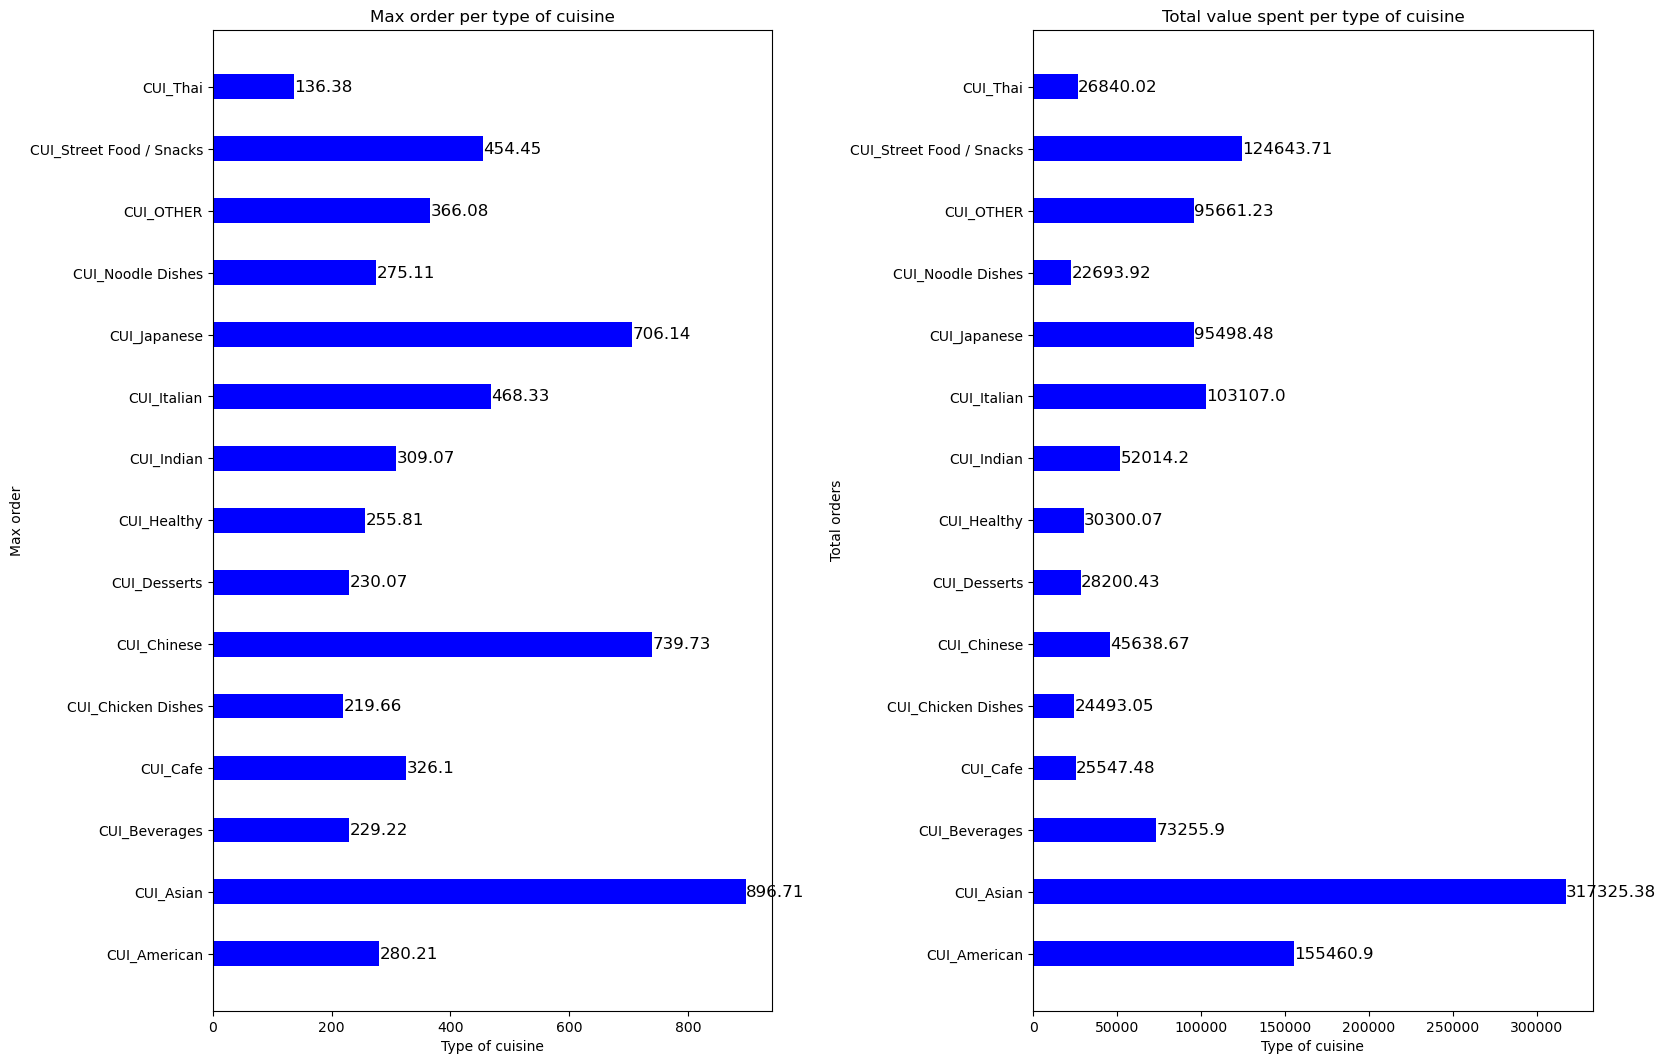

In [38]:
max_values = df[cui_columns].max()
sum_values = df[cui_columns].sum().round(2)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(17, 11))

axes[0].barh(max_values.index, max_values.values, color='blue', height=0.4)
axes[0].set_title('Max order per type of cuisine')
axes[0].set_xlabel('Type of cuisine')
axes[0].set_ylabel('Max order')
for i in range(len(max_values)):
    axes[0].text(max_values.values[i] + 1, i, str(max_values.values[i]), va='center', fontsize=12)

axes[1].barh(sum_values.index, sum_values.values, color='blue', height=0.4)
axes[1].set_title('Total value spent per type of cuisine')
axes[1].set_xlabel('Type of cuisine')
axes[1].set_ylabel('Total orders')
for i in range(len(sum_values)):
    axes[1].text(sum_values.values[i] + 1, i, str(sum_values.values[i]),va='center', fontsize=12)

plt.tight_layout(pad=2.0)
plt.show()

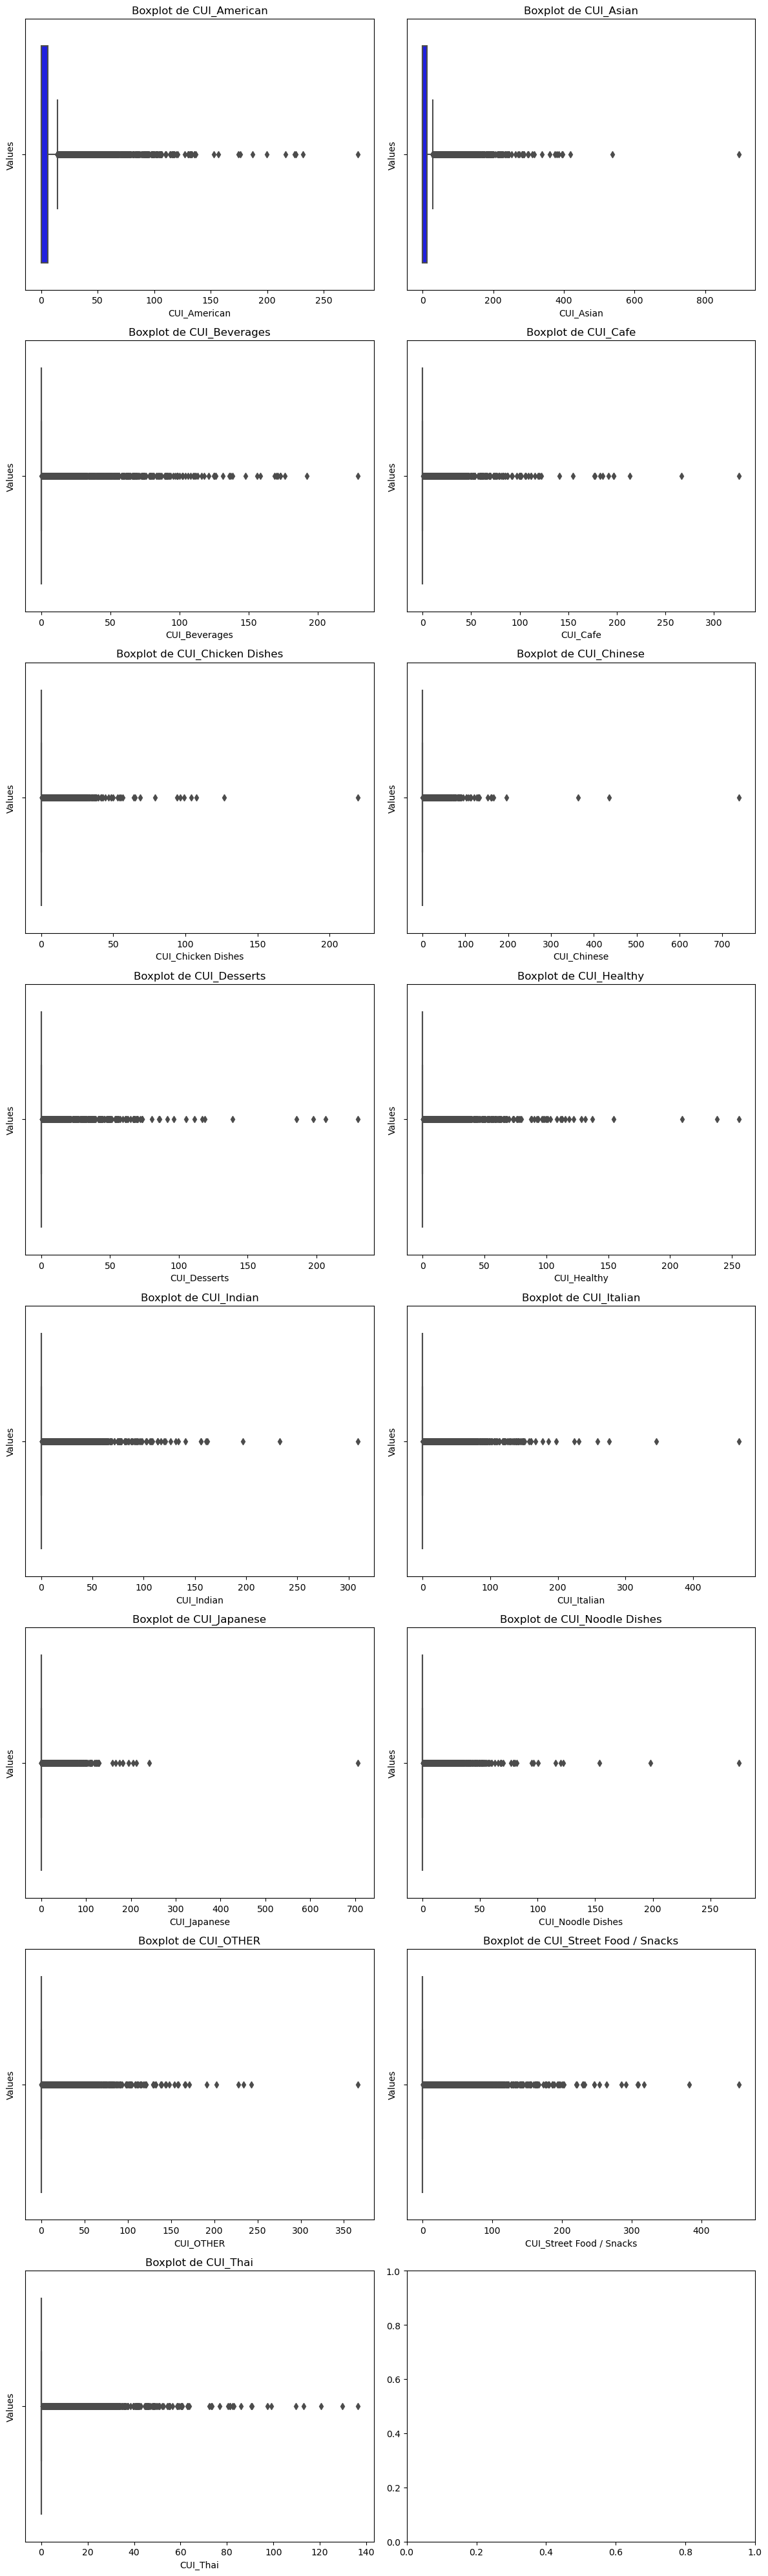

In [39]:
fig, axes = plt.subplots(8, 2, figsize=(12, 40))

axes = axes.flatten()

for i, column in enumerate(cui_columns):
    axes[i].set_ylim(0, 150)
    sns.boxplot(x=df[column], color='blue', ax=axes[i])
    axes[i].set_title(f'Boxplot de {column}')
    axes[i].set_ylabel('Values')

plt.tight_layout()  
plt.show()

In [40]:
#The boxplots are not readable like this because of the null values in each column. The 75% quartil is 0 in almost every cuisine
#So we will repeat it but without the nulls

In [41]:
df_sem0 = df[df[cui_columns] != 0]
df_sem0[cui_columns].describe() #check if the nulls are out

,CUI_American,CUI_Asian,CUI_Beverages,CUI_Cafe,CUI_Chicken Dishes,CUI_Chinese,CUI_Desserts,CUI_Healthy,CUI_Indian,CUI_Italian,CUI_Japanese,CUI_Noodle Dishes,CUI_OTHER,CUI_Street Food / Snacks,CUI_Thai
count,10791.000000,11896.000000,5431.000000,1366.000000,3248.000000,3522.000000,2016.000000,2169.000000,3448.000000,6448.000000,6300.000000,2226.000000,7041.000000,4244.000000,2378.000000
mean,14.406533,26.674965,13.488474,18.702401,7.540964,12.958169,13.988309,13.969604,15.085325,15.990540,15.158489,10.194933,13.586313,29.369394,11.286804
std,16.230456,32.272855,16.454006,25.098451,8.959083,21.408096,15.950535,17.833984,17.592123,20.536117,18.445908,14.078502,16.980684,32.683028,12.070007
min,0.410000,0.440000,0.320000,0.660000,0.340000,0.440000,0.410000,0.430000,0.460000,0.340000,0.430000,0.370000,0.360000,0.440000,0.500000
25%,5.450000,8.177500,4.805000,6.692500,2.800000,4.292500,5.677500,5.260000,5.585000,4.980000,5.900000,3.082500,4.720000,8.752500,4.802500
50%,9.310000,17.980000,7.690000,11.360000,5.280000,7.460000,11.295000,8.560000,10.180000,10.260000,11.150000,6.045000,8.670000,18.940000,7.675000
75%,18.210000,31.320000,17.575000,20.360000,9.325000,15.562500,18.302500,16.880000,17.722500,19.280000,18.460000,11.797500,16.050000,37.150000,13.492500
max,280.210000,896.710000,229.220000,326.100000,219.660000,739.730000,230.070000,255.810000,309.070000,468.330000,706.140000,275.110000,366.080000,454.450000,136.380000


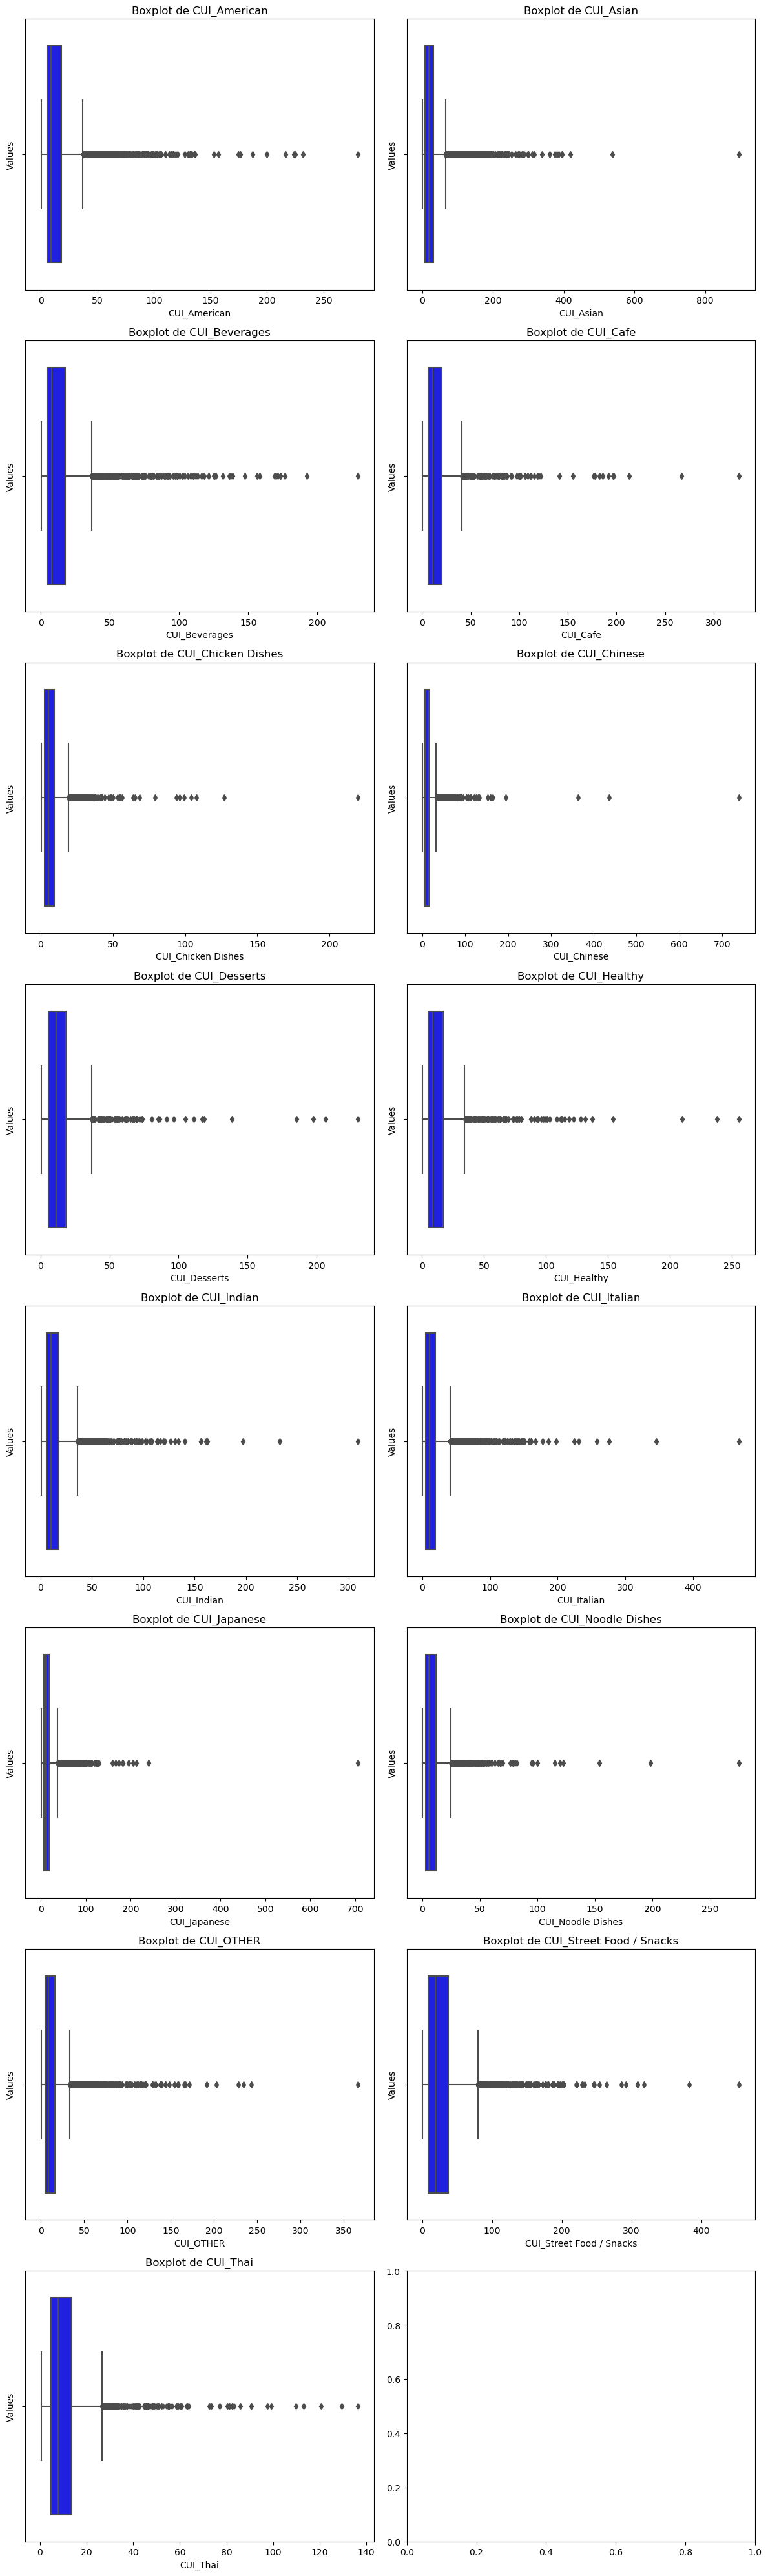

In [42]:
fig, axes = plt.subplots(8, 2, figsize=(12, 40), tight_layout=True)

axes = axes.flatten()

for i, column in enumerate(cui_columns):
    #axes[i].set_ylim(0, 150)
    sns.boxplot(x=df_sem0[column], color='blue', ax=axes[i])
    axes[i].set_title(f'Boxplot de {column}')
    axes[i].set_ylabel('Values')

plt.tight_layout()  
plt.show()

In [43]:
#We noticed that in every cuisine there is at least one big outlier and we want to compare it with the region to see if there is a correlation. Check if all the outliers come from the same region

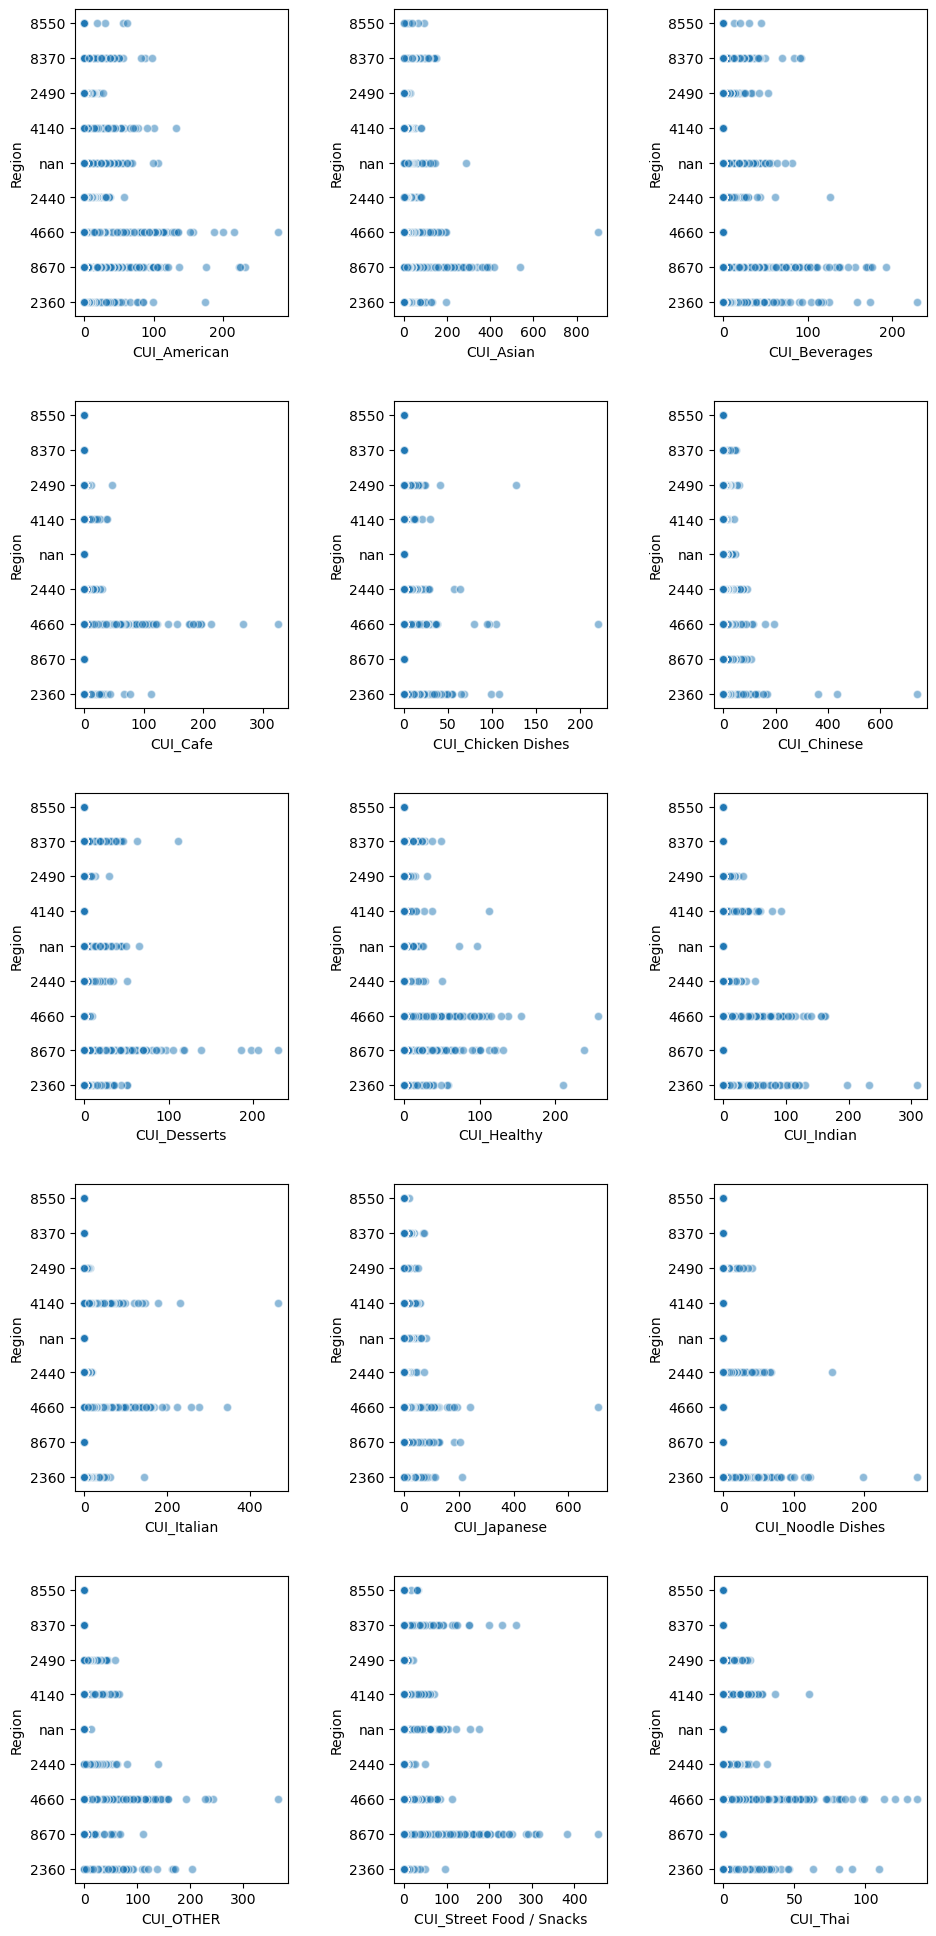

In [44]:
fig, axes = plt.subplots(5, 3, figsize=(10,20))

axes = axes.flatten()

for i, column in enumerate(cui_columns):
    axes[i].scatter(x=df[column], y=df['customer_region'].astype(str), edgecolors="white", alpha=0.5)
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Region')

plt.tight_layout(pad=3.0) 
plt.show()

In [45]:
#As we expected the outliers are in the last 3 regions. So that regions tend to spend more.
#we will do the same comparison with age

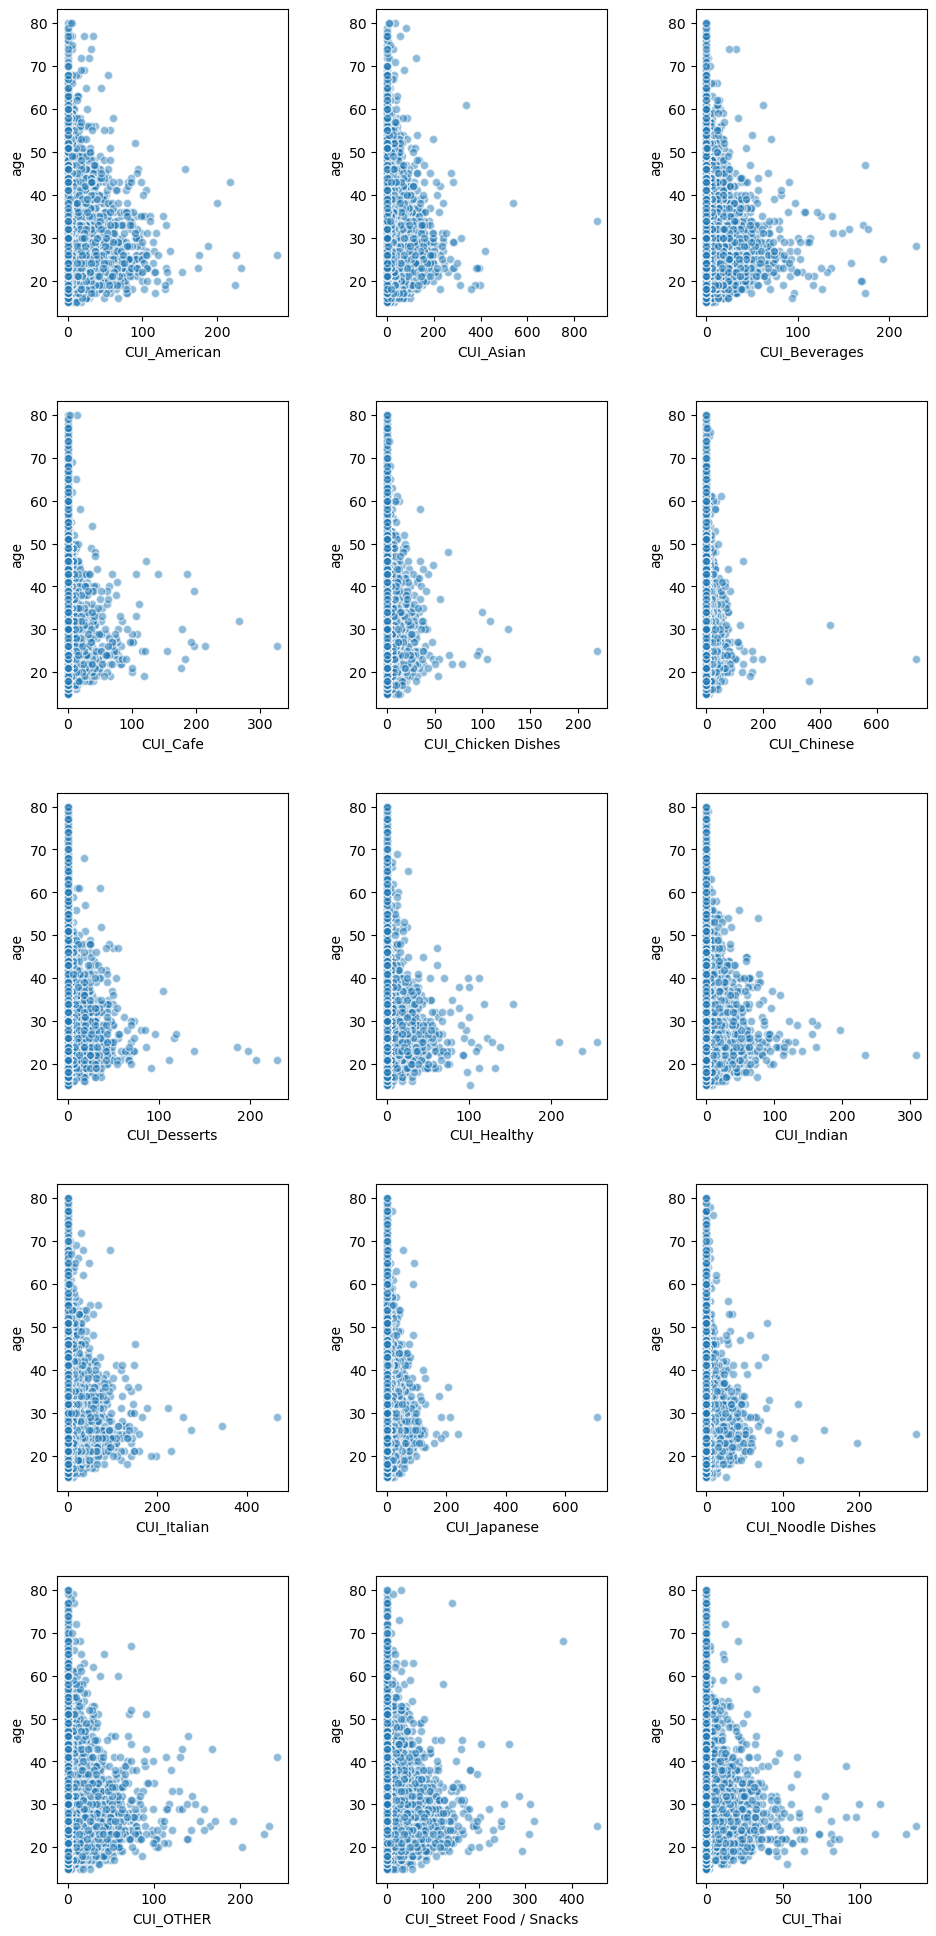

In [46]:
fig, axes = plt.subplots(5, 3, figsize=(10,20))

axes = axes.flatten()

for i, column in enumerate(cui_columns):
    axes[i].scatter(x=df[column], y=df['customer_age'], edgecolors="white", alpha=0.5)
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('age')

plt.tight_layout(pad=3.0) 
plt.show()

In [47]:
#we noticed that the bigger orders are placed by people between the 20 years old and 30 years old. 
#However we've seen before that we have a lot more data of younger people (the mean of customer_age is 27.507545).

In [102]:
regions = df["customer_region"].unique()

for region in regions: 
    unique_region = df[df["customer_region"] == region]
    total = unique_region[cui_columns].sum(axis = 0)
    
    radar = pd.DataFrame(dict(r=total, theta=cui_columns))
    fig = px.line_polar(radar, r='r', theta='theta', line_close=True)
    fig.update_layout(title=f'Region {region} Radar Chart')
    fig.show()

AttributeError: 'DataFrame' object has no attribute 'append'

In [48]:
#PAYMENT METHOD

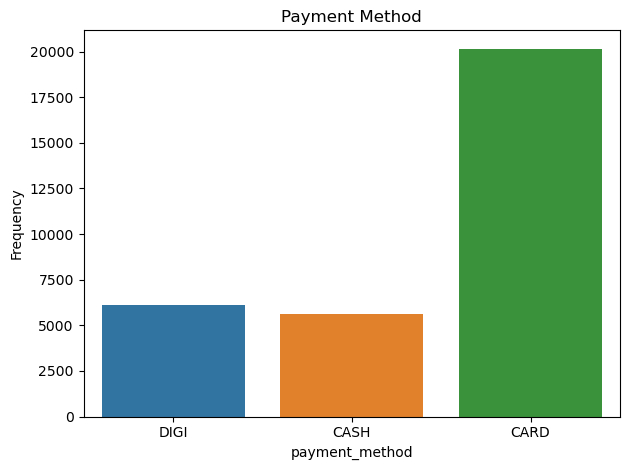

In [96]:
sns.countplot(x=df['payment_method'])
plt.title('Payment Method')
plt.ylabel('Frequency')

axes = axes.flatten()
plt.tight_layout()  
plt.show()

In [ ]:
# fazer outro de barras mas com label de idade, é preciso por idade em categorias (max 3)

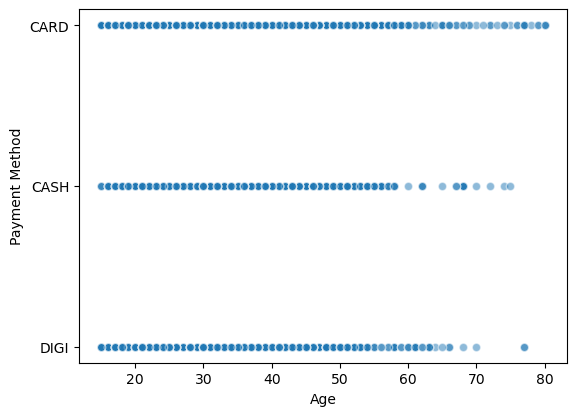

In [50]:
plt.scatter(x=df['customer_age'], y=df['payment_method'], edgecolors="white", alpha=0.5)
plt.xlabel('Age')
plt.ylabel('Payment Method')

plt.tight_layout(pad=3.0) 
plt.show()

In [51]:
df['is_chain'].describe()

count    31875.000000
mean         2.819357
std          3.977977
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         83.000000
Name: is_chain, dtype: float64

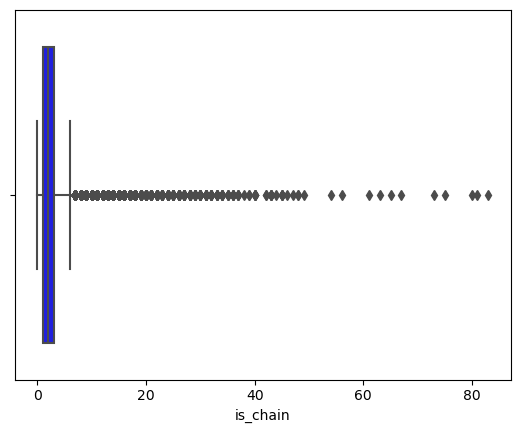

In [52]:
sns.boxplot(x=df['is_chain'], color='blue')
plt.show()